# State Farm Distracted Driver Detection

In [1]:
# %pip install ultralytics
# %pip install split-folders
# %pip install -U ipywidgets




In [71]:
import csv
import os
from glob import glob
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from ultralytics import YOLO
import splitfolders
import pandas as pd
import numpy as np
from IPython.display import display, Image
from sklearn.metrics import accuracy_score

## Loading the data

In [3]:
data = {}

with open('../datasets/state-farm-distracted-driver-detection/driver_imgs_list.csv') as file:
    read_file = csv.reader(file)
    read_file = list(read_file)
    
    for row in read_file[1:]:
        key = row[1]
        if key in data:
            data[key].append(row[2])
        else:
            data[key] = [row[2]]

In [4]:
data

{'c0': ['img_44733.jpg',
  'img_72999.jpg',
  'img_25094.jpg',
  'img_69092.jpg',
  'img_92629.jpg',
  'img_3370.jpg',
  'img_67639.jpg',
  'img_58560.jpg',
  'img_35779.jpg',
  'img_10012.jpg',
  'img_70354.jpg',
  'img_54617.jpg',
  'img_26684.jpg',
  'img_82409.jpg',
  'img_5585.jpg',
  'img_19029.jpg',
  'img_40930.jpg',
  'img_31547.jpg',
  'img_87373.jpg',
  'img_10627.jpg',
  'img_66355.jpg',
  'img_97714.jpg',
  'img_37344.jpg',
  'img_54848.jpg',
  'img_59964.jpg',
  'img_70675.jpg',
  'img_43317.jpg',
  'img_13585.jpg',
  'img_63064.jpg',
  'img_91058.jpg',
  'img_79799.jpg',
  'img_18198.jpg',
  'img_55108.jpg',
  'img_87789.jpg',
  'img_11582.jpg',
  'img_24152.jpg',
  'img_28404.jpg',
  'img_8868.jpg',
  'img_14949.jpg',
  'img_41276.jpg',
  'img_70611.jpg',
  'img_42895.jpg',
  'img_87995.jpg',
  'img_40990.jpg',
  'img_68866.jpg',
  'img_71265.jpg',
  'img_90102.jpg',
  'img_30954.jpg',
  'img_3570.jpg',
  'img_59000.jpg',
  'img_48323.jpg',
  'img_13073.jpg',
  'img_806

In [5]:
classes_list = list(data.keys())
classes_list

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [6]:
dataset_folder = '../datasets/state-farm-distracted-driver-detection/imgs/'

train_dir = os.path.join(dataset_folder, 'train/')
test_dir = os.path.join(dataset_folder, 'test/')

In [7]:
print('Number of images in the training dataset : ', str(len(glob(train_dir+'*/*'))))
print('Number of images in the testing dataset : ', str(len(glob(test_dir+'*'))))

Number of images in the training dataset :  22424
Number of images in the testing dataset :  79726


In [ ]:
# Need to separate the training set and the validation set.

### Writing helper function for creating directories for training set, validation set and test set

In [8]:
def remove_directory(path):
    for root, dirs, files in os.walk(path, topdown = False):
        for name in files:
            file_path = os.path.join(root, name)
            os.remove(file_path)
        for name in dirs:
            dir_path = os.path.join(root, name)
            os.rmdir(dir_path)
    os.rmdir(path)

In [9]:
def create_directories(paths, subfolders):
    for path in paths:
        if os.path.exists(path):
            remove_directory(path)
        
        for folder in subfolders:
            subfolder_path = os.path.join(path, folder)
            os.makedirs(subfolder_path)

In [105]:
paths = ['../datasets/state-farm-distracted-driver-detection/cleaned_dataset/train',
         '../datasets/state-farm-distracted-driver-detection/cleaned_dataset/val',
        '../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test']

In [102]:
subfolders = classes_list

In [103]:
create_directories(paths, subfolders)

### Creating the cleaned dataset using the above helper functions we have created

In [111]:
split_size = [0.6, 0.2]


for clas, images in data.items():
    # print(len(images))
    train_size = int(split_size[0]*len(images))
    # print("Train size: ", train_size)
    
    test_size = int(split_size[1]*len(images))
    #print("Test size: ", test_size)
    
    train_images = images[:train_size]
    # print("Train Images Length", len(train_images))
    
    val_images = images[train_size: train_size + test_size]
    # print("Val Images Length", len(val_images))
    
    test_images = images[train_size + test_size:]
    # print("Test Images Length", len(test_images))
    
    
    
    for image in train_images:
        source = os.path.join(train_dir, clas, image)
        # print(os.path.exists(source))
        dest = os.path.join(paths[0], clas, image)
        copyfile(source, dest)
    
    for image in val_images:
        source = os.path.join(train_dir, clas, image)
        dest = os.path.join(paths[1], clas, image)
        copyfile(source, dest)
    
    for image in test_images:
        source = os.path.join(train_dir, clas, image)
        dest = os.path.join(paths[2], clas, image)
        copyfile(source, dest)
    
    


### Using a better approach for creating the cleaned dataset using `splitfolders` module

### First deleting the cleaned dataset created usinfg the above method

In [112]:
remove_directory('../datasets/state-farm-distracted-driver-detection/cleaned_dataset')

### Creating the cleaned dataset now using splitfolder module

In [114]:
images_dir = '../datasets/state-farm-distracted-driver-detection/imgs/train'
output_folder = '../datasets/state-farm-distracted-driver-detection/cleaned_dataset' # Note: the function will create val, train, test sub directories by itself
split_ratio = (0.6, 0.2, 0.2)



splitfolders.ratio(images_dir, output= output_folder, seed = 10, ratio= split_ratio)

Copying files: 22424 files [00:04, 5266.22 files/s]


Done ! Just needed one line of code.

### From now, we will be using these Directory paths for our training, validation and testing purpose

In [115]:
train_dir = '../datasets/state-farm-distracted-driver-detection/cleaned_dataset/train'
val_dir = '../datasets/state-farm-distracted-driver-detection/cleaned_dataset/val'
test_dir = '../datasets/state-farm-distracted-driver-detection/cleaned_dataset/test'

## Creating Image data generator Function with Data Augmentation

In [ ]:
def imagedatageneration(train_dir, val_dir, test_dir, target_size, batch_size):
    train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                       rotation_range = 
                                      )
    train_generator = train_datagen.flow_from_directory(
                                                            train_dir,
                                                            target_size = target_size,
                                                            class_mode = 'categorical',
                                                            shuffle = True,
                                                            batch_size = batch_size
                                                        )
    
    

In [116]:
# train_dir = '../datasets/state-farm-distracted-driver-detection/train'
# val_dir = '../datasets/state-farm-distracted-driver-detection/val'

train_datagen = ImageDataGenerator(rescale = 1.0/255)

train_generator = train_datagen.flow_from_directory(
                                                        train_dir,
                                                        target_size = (256, 256),
                                                        class_mode = 'categorical',
                                                        shuffle = True,
                                                        batch_size = 32
                                                    )

val_datagen = ImageDataGenerator(rescale = 1.0/255)

val_generator = val_datagen.flow_from_directory(
                                                        val_dir,
                                                        target_size = (256, 256),
                                                        class_mode = 'categorical',
                                                        shuffle = True,
                                                        batch_size = 32
                                                )



Found 13451 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [117]:
es = EarlyStopping(monitor = 'val_acc', patience = 4, min_delta = 0.001)

## First Model -> Dense Model

In [118]:
model1 = tf.keras.models.Sequential([
    Flatten(input_shape = (256, 256, 3)),
    Dense(1024, activation = 'relu'),
    BatchNormalization(),
    Dense(512, activation = 'relu'),
    BatchNormalization(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'softmax')
])

In [119]:
model1.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['acc'])

In [120]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 1024)              201327616 
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               1

In [121]:
model1.fit(train_generator,
                   epochs = 20,
                   verbose = 1,
                   validation_data = val_generator,
                   callbacks = [es])

Epoch 1/20
421/421 [==============================] - 74s 174ms/step - loss: 0.9500 - acc: 0.6863 - val_loss: 1.2852 - val_acc: 0.6760
Epoch 2/20
421/421 [==============================] - 73s 173ms/step - loss: 0.1755 - acc: 0.9428 - val_loss: 0.6868 - val_acc: 0.8201
Epoch 3/20
421/421 [==============================] - 73s 173ms/step - loss: 0.1023 - acc: 0.9677 - val_loss: 0.1540 - val_acc: 0.9487
Epoch 4/20
421/421 [==============================] - 73s 173ms/step - loss: 0.0739 - acc: 0.9755 - val_loss: 0.5045 - val_acc: 0.8547
Epoch 5/20
421/421 [==============================] - 75s 178ms/step - loss: 0.0762 - acc: 0.9752 - val_loss: 0.6405 - val_acc: 0.8451
Epoch 6/20
421/421 [==============================] - 74s 175ms/step - loss: 0.0657 - acc: 0.9784 - val_loss: 0.2330 - val_acc: 0.9255
Epoch 7/20
421/421 [==============================] - 75s 178ms/step - loss: 0.0379 - acc: 0.9886 - val_loss: 0.4572 - val_acc: 0.8788


## Second Model -> CNN Model

In [ ]:
model2 = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (256, 256, 3)),
    Conv2D(32, (3, 3), activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation = 'relu'),
    Conv2D(64, (3, 3), activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation = 'relu'),
    BatchNormalization(),
    Flatten(),
    Dense(512, activation = 'relu'),
    BatchNormalization(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'softmax')
])

In [ ]:
model2.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['acc'])
model2.summary()

In [ ]:
model2.fit(train_generator,
          epochs = 20,
          verbose = 1,
          validation_data = val_generator,
          callbacks = [es])

## Third Model -> VGG16

In [ ]:
pretrained_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3))
pretrained_model.summary()

In [ ]:
# for layer in pretrained_model.layers[:-5]:
#     layer.trainable = False
    

In [ ]:
last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output

model3 = tf.keras.models.Sequential([ 
    pretrained_model,
    Flatten(),
    Dense(2048, activation = 'relu'),
    Dense(1024, activation = 'relu'),
    Dropout(0.2),
    Dense(256, activation = 'relu'),
    Dropout(0.2),
    Dense(10, activation = 'softmax')
    
])

In [ ]:
model3.compile(optimizer = Adam(learning_rate = 0.005), loss = 'categorical_crossentropy', metrics = ['acc'])
model3.summary()

In [ ]:
model3.fit(train_generator,
          steps_per_epoch = 250,
          epochs = 20,
          verbose = 1,
          validation_steps = 50,
          validation_data = val_generator,
          callbacks = [es])

## Fourth Model -> ResNet50

In [ ]:
pretrained_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3))

In [ ]:
for layer in pretrained_model.layers[:-3]:
    layer.trainable = False

In [ ]:
model4 = tf.keras.models.Sequential([ 
    pretrained_model,
    Flatten(),
    Dense(512, activation = 'relu'),
    BatchNormalization(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'softmax')
])

In [ ]:
model4.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])
model4.summary()

In [ ]:
model4.fit(train_generator,
          steps_per_epoch = 250,
          epochs = 20,
          verbose = 1,
          validation_steps = 50,
          validation_data = val_generator,
          callbacks = [es])

## Fifth Model -> Yolo v9

In [30]:
model5 = YOLO('yolov8n-cls.pt')

In [31]:
splitfolders.ratio("../datasets/state-farm-distracted-driver-detection/imgs/train", output="../datasets/state-farm-distracted-driver-detection/output", seed = 1337, ratio=(0.7, 0.15, 0.15))

Copying files: 22424 files [00:04, 5530.26 files/s]


In [32]:
results = model5.train(data = "../datasets/state-farm-distracted-driver-detection/output", epochs = 10)

Ultralytics YOLOv8.2.38 🚀 Python-3.10.14 torch-2.3.1 CPU (Apple M2 Max)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=../datasets/state-farm-distracted-driver-detection/output, epochs=10, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True

train: Scanning /Users/deep/Desktop/Data_Science_Projects/datasets/state-farm-distracted-driver-detection/output/train... 15692 images, 0 corrupt: 100%|██████
val: Scanning /Users/deep/Desktop/Data_Science_Projects/datasets/state-farm-distracted-driver-detection/output/val... 3358 images, 0 corrupt: 100%|██████████|

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)


TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs/classify/train2
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 105/105 [01:01<00:00,  1.71it/s]

                   all      0.923      0.998

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 105/105 [01:02<00:00,  1.68it/s]

                   all      0.974      0.999

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 105/105 [01:01<00:00,  1.71it/s]

                   all      0.976          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 105/105 [01:01<00:00,  1.71it/s]

                   all      0.982          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 105/105 [01:01<00:00,  1.70it/s]

                   all      0.988          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 105/105 [01:02<00:00,  1.69it/s]

                   all      0.991      0.999

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 105/105 [01:01<00:00,  1.70it/s]

                   all       0.99          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 105/105 [01:01<00:00,  1.70it/s]

                   all      0.992      0.999

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 105/105 [01:01<00:00,  1.70it/s]

                   all      0.993          1

      Epoch    GPU_mem       loss  Instances       Size



      10/10         0G    0.07235         12        224: 100%|██████████| 981/981 [09:19<00:00,  1.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 105/105 [01:01<00:00,  1.70it/s]

                   all      0.994          1

10 epochs completed in 1.849 hours.
Optimizer stripped from runs/classify/train2/weights/last.pt, 3.0MB


Optimizer stripped from runs/classify/train2/weights/best.pt, 3.0MB

Validating runs/classify/train2/weights/best.pt...
Ultralytics YOLOv8.2.38 🚀 Python-3.10.14 torch-2.3.1 CPU (Apple M2 Max)
YOLOv8n-cls summary (fused): 73 layers, 1447690 parameters, 0 gradients, 3.3 GFLOPs
train: /Users/deep/Desktop/Data_Science_Projects/datasets/state-farm-distracted-driver-detection/output/train... found 15692 images in 10 classes ✅ 
val: /Users/deep/Desktop/Data_Science_Projects/datasets/state-farm-distracted-driver-detection/output/val... found 3358 images in 10 classes ✅ 
test: /Users/deep/Desktop/Data_Science_Projects/datasets/state-farm-distracted-driver-detection/output/test... found 3374 images in 10 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 105/105 [00:59<00:00,  1.75it/s]


                   all      0.994          1
Speed: 0.0ms preprocess, 15.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2
Results saved to runs/classify/train2


In [33]:
model5.val()

Ultralytics YOLOv8.2.38 🚀 Python-3.10.14 torch-2.3.1 CPU (Apple M2 Max)
YOLOv8n-cls summary (fused): 73 layers, 1447690 parameters, 0 gradients, 3.3 GFLOPs
train: /Users/deep/Desktop/Data_Science_Projects/datasets/state-farm-distracted-driver-detection/output/train... found 15692 images in 10 classes ✅ 
val: /Users/deep/Desktop/Data_Science_Projects/datasets/state-farm-distracted-driver-detection/output/val... found 3358 images in 10 classes ✅ 
test: /Users/deep/Desktop/Data_Science_Projects/datasets/state-farm-distracted-driver-detection/output/test... found 3374 images in 10 classes ✅ 


val: Scanning /Users/deep/Desktop/Data_Science_Projects/datasets/state-farm-distracted-driver-detection/output/val... 3358 images, 0 corrupt: 100%|██████████|
               classes   top1_acc   top5_acc: 100%|██████████| 210/210 [01:00<00:00,  3.47it/s]


                   all      0.994          1
Speed: 0.0ms preprocess, 15.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train22


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x38ed431f0>
curves: []
curves_results: []
fitness: 0.9970220327377319
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9940440654754639, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9970220327377319}
save_dir: PosixPath('runs/classify/train22')
speed: {'preprocess': 0.00036316588210377965, 'inference': 15.554696836238676, 'loss': 7.994619418354955e-05, 'postprocess': 5.396013106527322e-05}
task: 'classify'
top1: 0.9940440654754639
top5: 1.0

In [36]:
df= pd.read_csv('./runs/classify/train2/results.csv')
df.head()

,epoch,train/loss,metrics/accuracy_top1,metrics/accuracy_top5,val/loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.33230,0.92287,0.99821,1.5743,0.000238,0.000238,0.000238
1,2,0.33685,0.97409,0.99881,1.4990,0.000429,0.000429,0.000429
2,3,0.24253,0.97558,0.99970,1.4930,0.000572,0.000572,0.000572
3,4,0.18162,0.98183,0.99970,1.4858,0.000502,0.000502,0.000502
4,5,0.15215,0.98779,1.00000,1.4768,0.000431,0.000431,0.000431


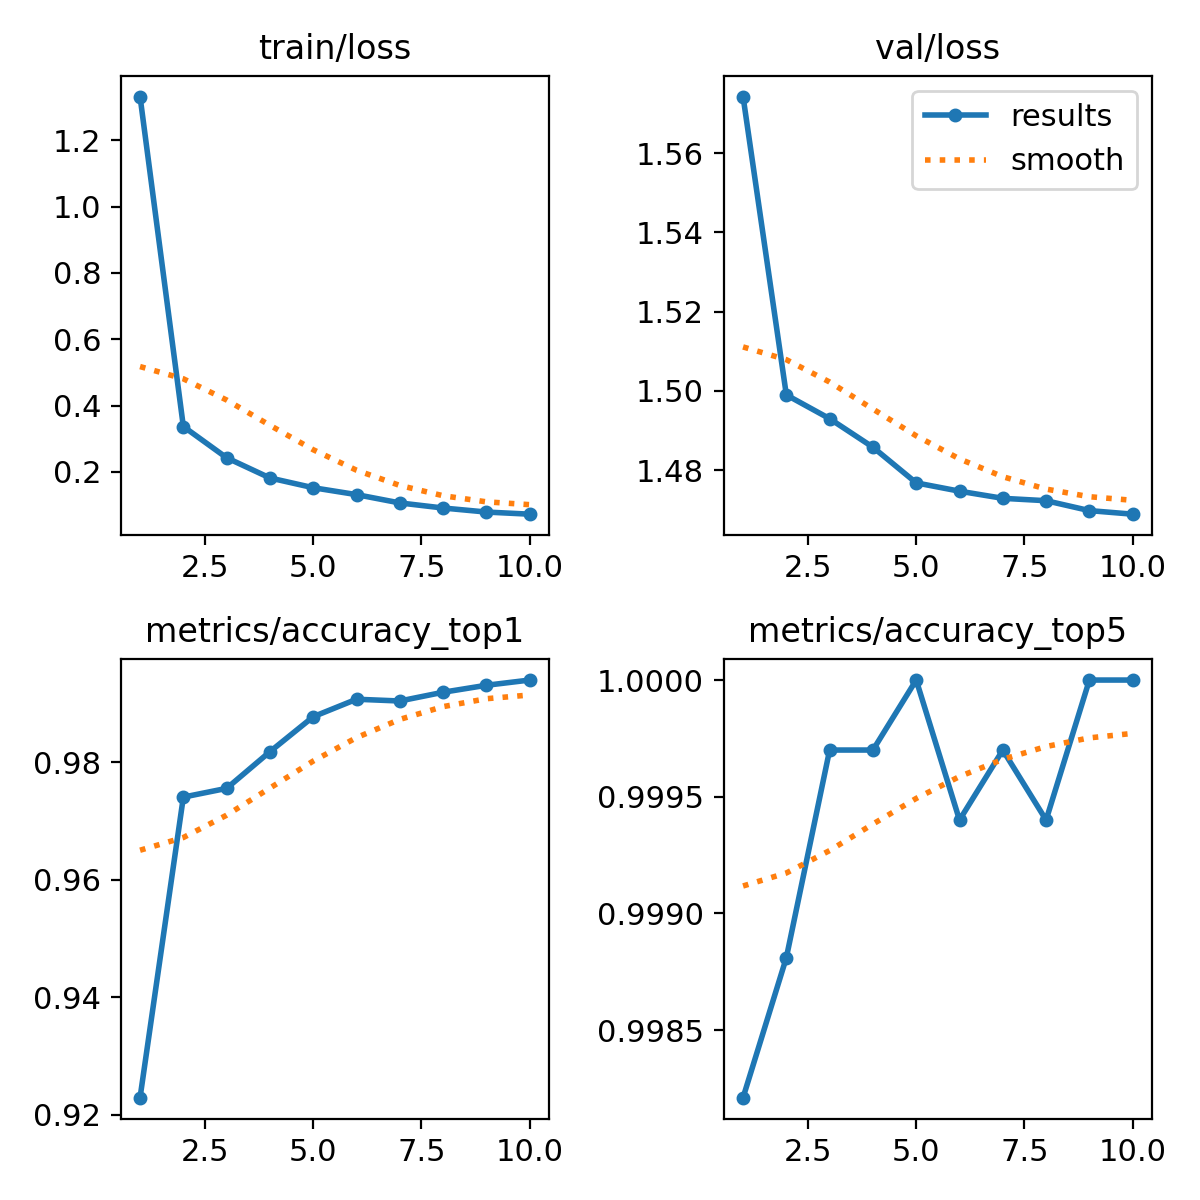

In [38]:
Image("./runs/classify/train2/results.png")

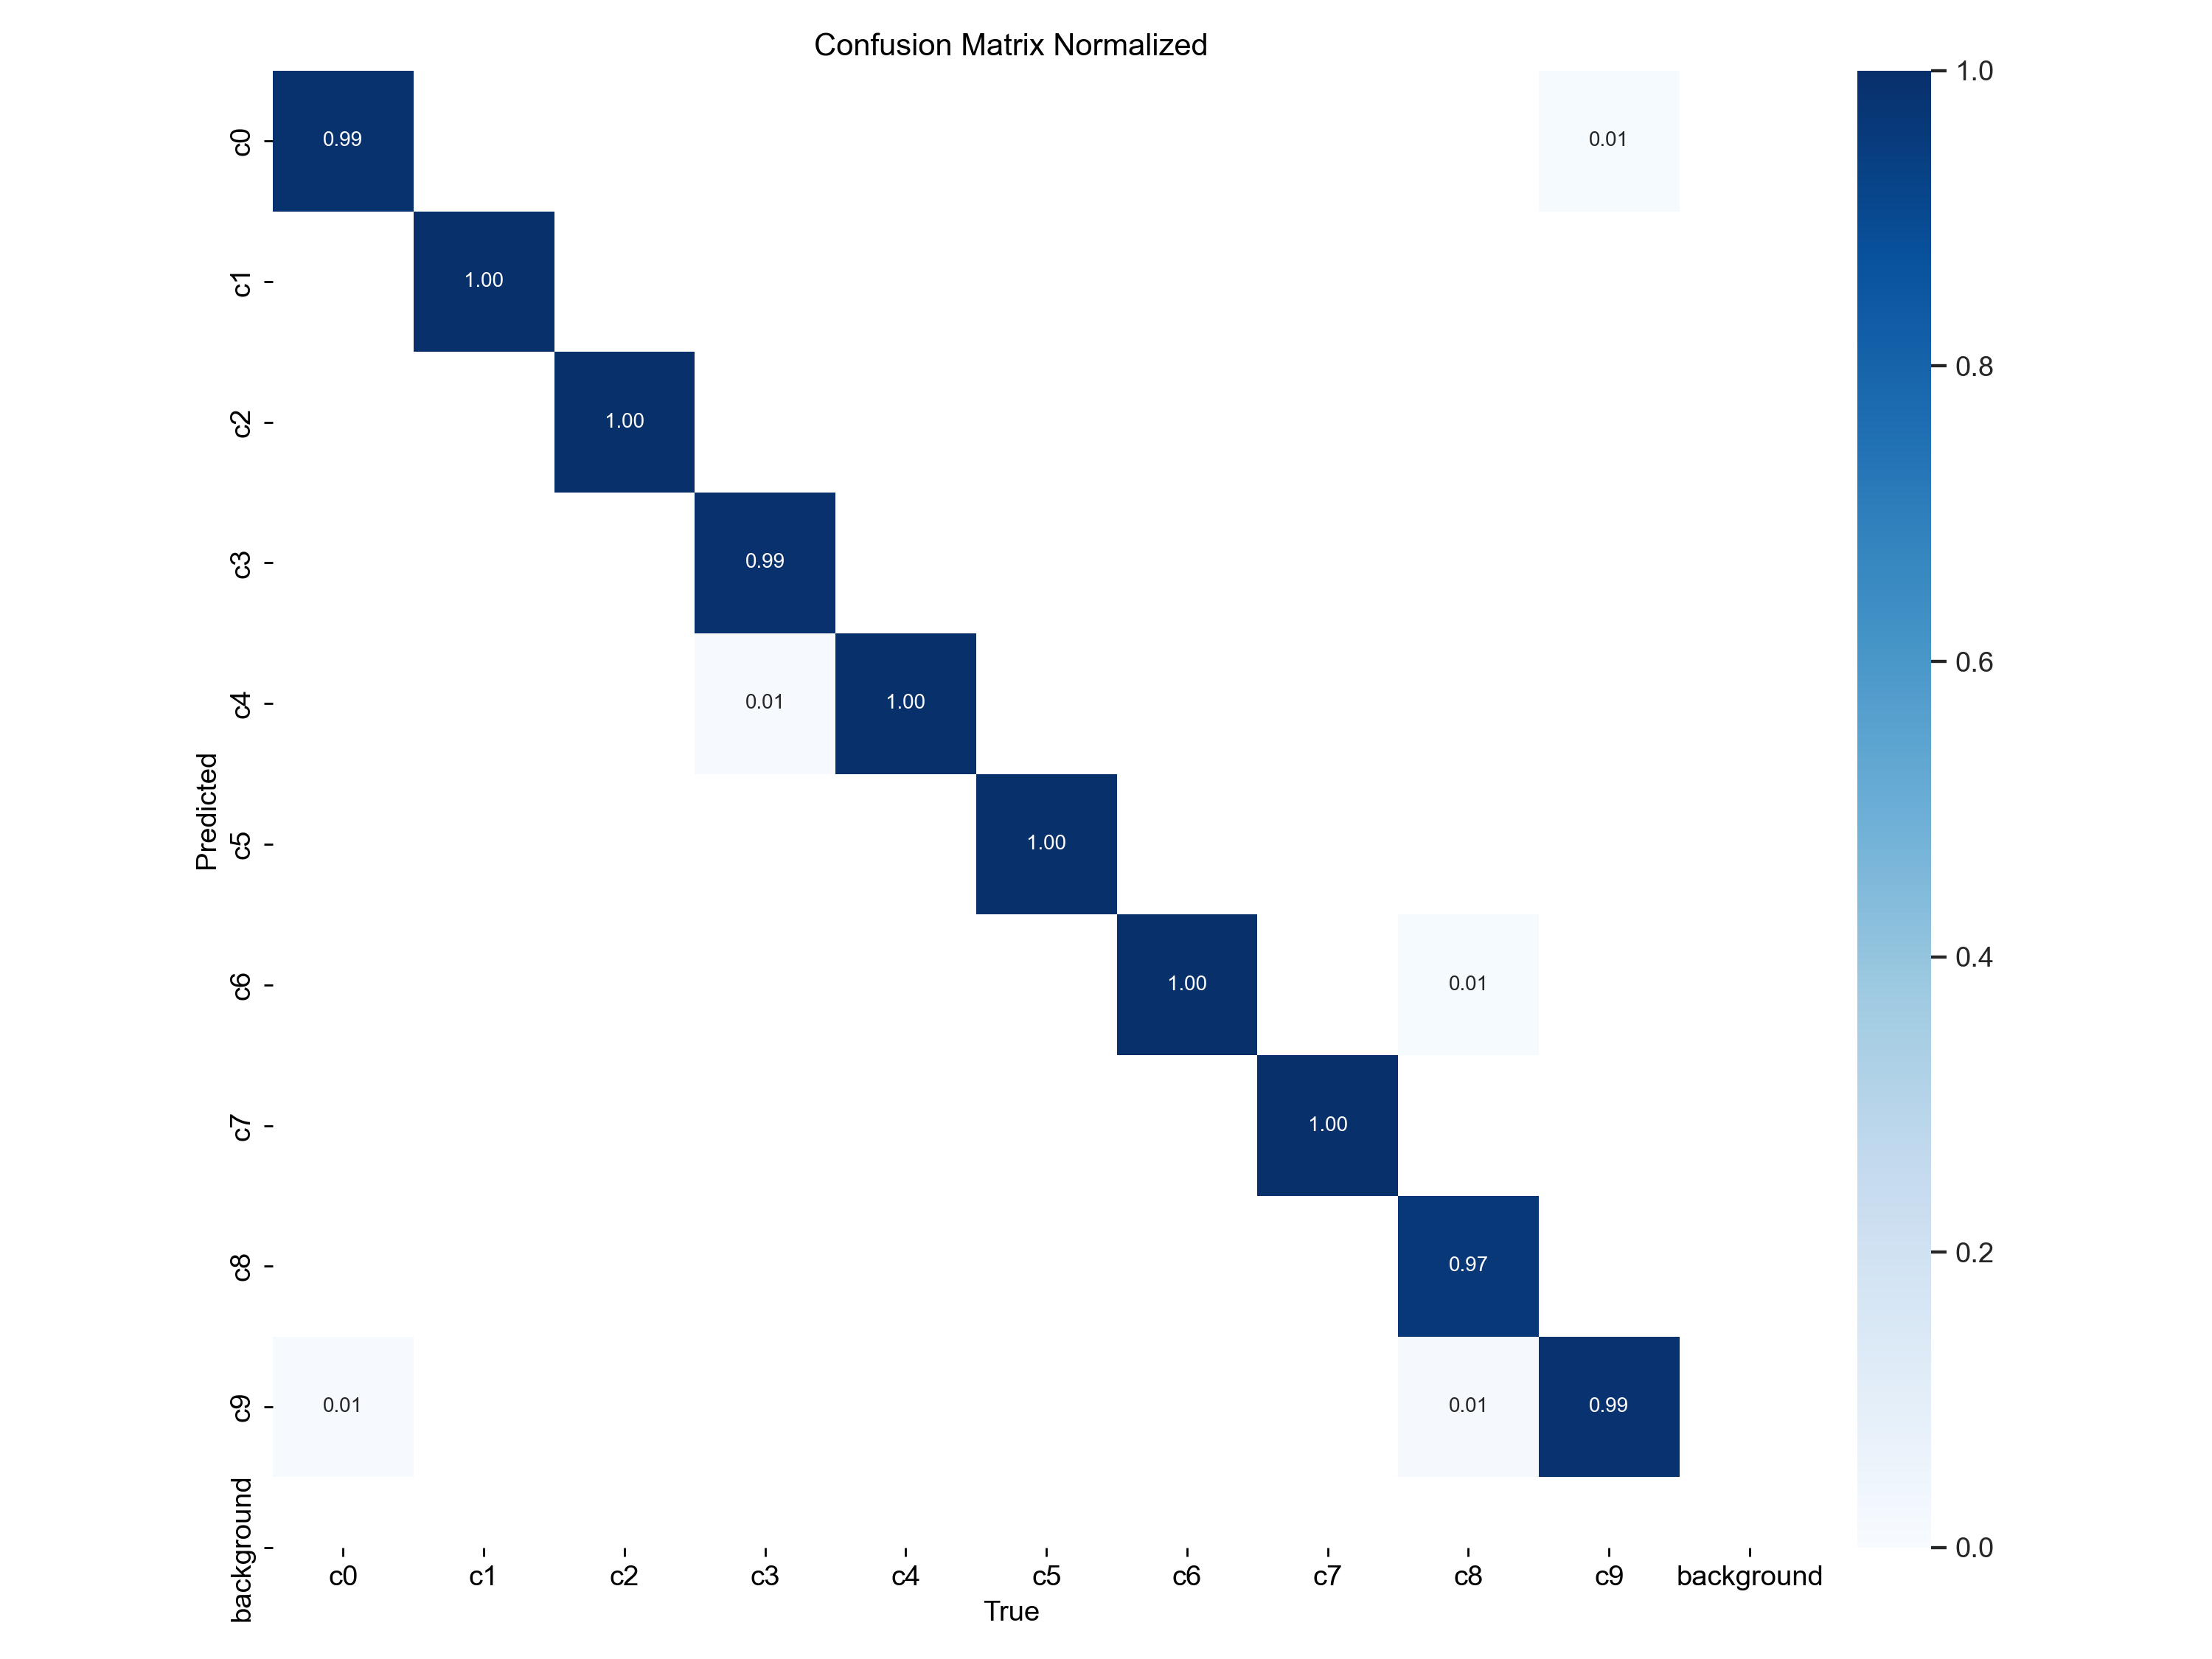

In [39]:
Image("./runs/classify/train2/confusion_matrix_normalized.png")


In [73]:
# classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
# path = "../datasets/state-farm-distracted-driver-detection/output/test/c1/"
# actual_class = 1
# model_weights = "./runs/classify/train2/weights/best.pt"
# pred = [(path+i,model5.predict(path+i, model = model_weights)[0].probs.top1, actual_class) for i in os.listdir(path)[:45]]


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_87088.jpg: 224x224 c1 0.99, c0 0.01, c5 0.00, c6 0.00, c2 0.00, 11.9ms
Speed: 5.8ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_68267.jpg: 224x224 c1 1.00, c6 0.00, c0 0.00, c3 0.00, c8 0.00, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_8845.jpg: 224x224 c1 1.00, c0 0.00, c5 0.00, c2 0.00, c3 0.00, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Use


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_1916.jpg: 224x224 c1 1.00, c3 0.00, c6 0.00, c2 0.00, c0 0.00, 5.9ms
Speed: 2.0ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_19099.jpg: 224x224 c1 1.00, c6 0.00, c2 0.00, c5 0.00, c0 0.00, 6.0ms
Speed: 2.6ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_7368.jpg: 224x224 c1 1.00, c6 0.00, c2 0.00, c9 0.00, c8 0.00, 6.1ms
Speed: 1.5ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/

In [94]:
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
test_images_path = "../datasets/state-farm-distracted-driver-detection/output/test/"
model_weights = "./runs/classify/train2/weights/best.pt"

predicted_list = []

for clas in classes:
    image_dir = os.path.join(test_images_path, clas)
    # print(image_dir)
    images_list = os.listdir(image_dir)
    # print(images_list)
    # Class label in the form of 0 to 9
    class_label = int(clas[-1])
    # print(class_label)
    for image in images_list:
        path = os.path.join(image_dir, image)
        # print(path)
        y_actual = class_label
        y_predicted = model5.predict(path, model = model_weights)[0].probs.top1
        predicted_list.append([path, y_actual, y_predicted])


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_34530.jpg: 224x224 c0 1.00, c8 0.00, c6 0.00, c1 0.00, c5 0.00, 15.8ms
Speed: 5.2ms preprocess, 15.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_64461.jpg: 224x224 c0 1.00, c9 0.00, c8 0.00, c1 0.00, c5 0.00, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_44969.jpg: 224x224 c0 1.00, c5 0.00, c9 0.00, c8 0.00, c1 0.00, 9.1ms
Speed: 2.4ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Us


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_72599.jpg: 224x224 c0 1.00, c5 0.00, c8 0.00, c9 0.00, c2 0.00, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_68933.jpg: 224x224 c0 1.00, c8 0.00, c3 0.00, c9 0.00, c4 0.00, 8.7ms
Speed: 1.9ms preprocess, 8.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_91414.jpg: 224x224 c0 1.00, c9 0.00, c5 0.00, c1 0.00, c3 0.00, 7.0ms
Speed: 2.6ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_5585.jpg: 224x224 c0 1.00, c9 0.00, c3 0.00, c4 0.00, c1 0.00, 5.6ms
Speed: 1.9ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_66660.jpg: 224x224 c0 1.00, c5 0.00, c9 0.00, c1 0.00, c8 0.00, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_9368.jpg: 224x224 c0 1.00, c9 0.00, c3 0.00, c5 0.00, c1 0.00, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_50058.jpg: 224x224 c0 1.00, c5 0.00, c9 0.00, c8 0.00, c1 0.00, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_25389.jpg: 224x224 c0 1.00, c1 0.00, c8 0.00, c3 0.00, c9 0.00, 6.2ms
Speed: 1.7ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_73468.jpg: 224x224 c0 1.00, c9 0.00, c3 0.00, c4 0.00, c8 0.00, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_72300.jpg: 224x224 c0 1.00, c9 0.00, c1 0.00, c8 0.00, c3 0.00, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_47393.jpg: 224x224 c0 1.00, c6 0.00, c1 0.00, c8 0.00, c5 0.00, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_98733.jpg: 224x224 c0 1.00, c9 0.00, c3 0.00, c8 0.00, c4 0.00, 6.1ms
Speed: 1.8ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_41911.jpg: 224x224 c0 1.00, c9 0.00, c5 0.00, c8 0.00, c1 0.00, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_18680.jpg: 224x224 c0 1.00, c9 0.00, c3 0.00, c5 0.00, c4 0.00, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_69086.jpg: 224x224 c0 1.00, c9 0.00, c1 0.00, c8 0.00, c3 0.00, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_54673.jpg: 224x224 c0 1.00, c8 0.00, c9 0.00, c3 0.00, c5 0.00, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_69280.jpg: 224x224 c0 1.00, c5 0.00, c3 0.00, c9 0.00, c6 0.00, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_24419.jpg: 224x224 c0 1.00, c1 0.00, c3 0.00, c9 0.00, c2 0.00, 5.9ms
Speed: 2.0ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_54857.jpg: 224x224 c0 1.00, c5 0.00, c1 0.00, c8 0.00, c9 0.00, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_56098.jpg: 224x224 c0 1.00, c5 0.00, c9 0.00, c1 0.00, c8 0.00, 8.2ms
Speed: 2.5ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_48339.jpg: 224x224 c0 1.00, c9 0.00, c5 0.00, c2 0.00, c8 0.00, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_58330.jpg: 224x224 c0 1.00, c5 0.00, c3 0.00, c9 0.00, c1 0.00, 6.0ms
Speed: 1.8ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_73162.jpg: 224x224 c0 1.00, c3 0.00, c9 0.00, c1 0.00, c5 0.00, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_74157.jpg: 224x224 c0 0.99, c5 0.01, c1 0.00, c6 0.00, c7 0.00, 7.0ms
Speed: 1.7ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_91696.jpg: 224x224 c0 1.00, c9 0.00, c1 0.00, c8 0.00, c3 0.00, 6.2ms
Speed: 2.6ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_93917.jpg: 224x224 c0 1.00, c9 0.00, c1 0.00, c3 0.00, c8 0.00, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_5869.jpg: 224x224 c0 1.00, c5 0.00, c9 0.00, c1 0.00, c8 0.00, 5.7ms
Speed: 1.8ms preprocess, 5.7ms inference, 0.3ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_52419.jpg: 224x224 c0 1.00, c3 0.00, c1 0.00, c8 0.00, c9 0.00, 5.9ms
Speed: 3.0ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_12203.jpg: 224x224 c0 1.00, c9 0.00, c3 0.00, c5 0.00, c4 0.00, 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_59772.jpg: 224x224 c0 0.97, c9 0.03, c4 0.00, c5 0.00, c3 0.00, 6.3ms
Speed: 2.3ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_41894.jpg: 224x224 c0 1.00, c3 0.00, c5 0.00, c1 0.00, c8 0.00, 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_80986.jpg: 224x224 c0 1.00, c9 0.00, c5 0.00, c3 0.00, c1 0.00, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_15221.jpg: 224x224 c0 1.00, c9 0.00, c8 0.00, c4 0.00, c3 0.00, 5.6ms
Speed: 1.8ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_77617.jpg: 224x224 c0 1.00, c1 0.00, c9 0.00, c5 0.00, c6 0.00, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 0.2ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_33727.jpg: 224x224 c0 1.00, c1 0.00, c9 0.00, c3 0.00, c8 0.00, 5.9ms
Speed: 1.7ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_81340.jpg: 224x224 c0 1.00, c1 0.00, c5 0.00, c3 0.00, c8 0.00, 5.5ms
Speed: 1.6ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_94969.jpg: 224x224 c0 1.00, c9 0.00, c3 0.00, c5 0.00, c4 0.00, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_38463.jpg: 224x224 c0 1.00, c5 0.00, c9 0.00, c1 0.00, c8 0.00, 5.9ms
Speed: 1.7ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_6481.jpg: 224x224 c0 1.00, c9 0.00, c5 0.00, c8 0.00, c4 0.00, 6.2ms
Speed: 1.7ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_48185.jpg: 224x224 c0 1.00, c8 0.00, c9 0.00, c5 0.00, c4 0.00, 6.1ms
Speed: 1.7ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_85888.jpg: 224x224 c0 1.00, c3 0.00, c8 0.00, c4 0.00, c9 0.00, 5.9ms
Speed: 2.6ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c0/img_87735.jpg: 224x224 c0 1.00, c9 0.00, c1 0.00, c3 0.00, c8 0.00, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_68267.jpg: 224x224 c1 1.00, c6 0.00, c0 0.00, c3 0.00, c8 0.00, 5.9ms
Speed: 2.7ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_8845.jpg: 224x224 c1 1.00, c0 0.00, c5 0.00, c2 0.00, c3 0.00, 5.8ms
Speed: 2.5ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_665.jpg: 224x224 c1 1.00, c0 0.00, c6 0.00, c3 0.00, c2 0.00, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/d


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_19099.jpg: 224x224 c1 1.00, c6 0.00, c2 0.00, c5 0.00, c0 0.00, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_7368.jpg: 224x224 c1 1.00, c6 0.00, c2 0.00, c9 0.00, c8 0.00, 5.5ms
Speed: 1.8ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_1043.jpg: 224x224 c1 1.00, c0 0.00, c2 0.00, c9 0.00, c3 0.00, 5.7ms
Speed: 1.9ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_61709.jpg: 224x224 c1 1.00, c6 0.00, c0 0.00, c8 0.00, c2 0.00, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_51806.jpg: 224x224 c1 1.00, c6 0.00, c2 0.00, c0 0.00, c8 0.00, 5.9ms
Speed: 1.8ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_17933.jpg: 224x224 c1 1.00, c6 0.00, c8 0.00, c7 0.00, c9 0.00, 7.7ms
Speed: 1.7ms preprocess, 7.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_5196.jpg: 224x224 c1 1.00, c6 0.00, c3 0.00, c8 0.00, c2 0.00, 5.5ms
Speed: 3.0ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_75227.jpg: 224x224 c1 1.00, c6 0.00, c0 0.00, c3 0.00, c2 0.00, 6.0ms
Speed: 1.7ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_10440.jpg: 224x224 c1 1.00, c0 0.00, c6 0.00, c8 0.00, c5 0.00, 5.5ms
Speed: 1.8ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_20334.jpg: 224x224 c1 1.00, c6 0.00, c2 0.00, c0 0.00, c8 0.00, 6.5ms
Speed: 1.7ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_50162.jpg: 224x224 c1 1.00, c6 0.00, c2 0.00, c8 0.00, c0 0.00, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_96093.jpg: 224x224 c1 1.00, c2 0.00, c6 0.00, c0 0.00, c3 0.00, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_79097.jpg: 224x224 c1 1.00, c6 0.00, c3 0.00, c0 0.00, c2 0.00, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_17014.jpg: 224x224 c1 1.00, c0 0.00, c3 0.00, c2 0.00, c6 0.00, 6.0ms
Speed: 1.8ms preprocess, 6.0ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_24145.jpg: 224x224 c1 1.00, c3 0.00, c8 0.00, c6 0.00, c2 0.00, 5.6ms
Speed: 2.1ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_81067.jpg: 224x224 c1 1.00, c9 0.00, c0 0.00, c6 0.00, c3 0.00, 6.5ms
Speed: 3.6ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_34186.jpg: 224x224 c1 0.79, c0 0.20, c6 0.01, c8 0.00, c2 0.00, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_59197.jpg: 224x224 c1 1.00, c0 0.00, c2 0.00, c9 0.00, c6 0.00, 6.0ms
Speed: 1.8ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_73581.jpg: 224x224 c1 1.00, c0 0.00, c6 0.00, c3 0.00, c2 0.00, 6.1ms
Speed: 1.7ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_43522.jpg: 224x224 c1 1.00, c3 0.00, c0 0.00, c6 0.00, c2 0.00, 9.2ms
Speed: 1.7ms preprocess, 9.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_85411.jpg: 224x224 c1 1.00, c6 0.00, c2 0.00, c8 0.00, c0 0.00, 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_54867.jpg: 224x224 c1 0.85, c2 0.04, c5 0.03, c3 0.02, c0 0.01, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_32843.jpg: 224x224 c1 1.00, c6 0.00, c0 0.00, c3 0.00, c2 0.00, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_5885.jpg: 224x224 c1 1.00, c0 0.00, c6 0.00, c2 0.00, c3 0.00, 6.0ms
Speed: 1.9ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_38428.jpg: 224x224 c1 0.99, c0 0.00, c3 0.00, c2 0.00, c6 0.00, 6.3ms
Speed: 2.5ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_5114.jpg: 224x224 c1 1.00, c8 0.00, c6 0.00, c3 0.00, c0 0.00, 5.7ms
Speed: 2.0ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_95423.jpg: 224x224 c1 1.00, c6 0.00, c2 0.00, c3 0.00, c5 0.00, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_46685.jpg: 224x224 c1 1.00, c3 0.00, c0 0.00, c8 0.00, c6 0.00, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_27535.jpg: 224x224 c1 1.00, c6 0.00, c9 0.00, c3 0.00, c7 0.00, 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_41665.jpg: 224x224 c1 1.00, c6 0.00, c9 0.00, c0 0.00, c2 0.00, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_21492.jpg: 224x224 c1 1.00, c8 0.00, c6 0.00, c2 0.00, c0 0.00, 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_53010.jpg: 224x224 c1 1.00, c9 0.00, c8 0.00, c3 0.00, c6 0.00, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_35342.jpg: 224x224 c1 1.00, c0 0.00, c9 0.00, c6 0.00, c5 0.00, 9.1ms
Speed: 1.7ms preprocess, 9.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_55112.jpg: 224x224 c1 1.00, c0 0.00, c6 0.00, c3 0.00, c2 0.00, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_86404.jpg: 224x224 c1 1.00, c6 0.00, c3 0.00, c2 0.00, c4 0.00, 6.5ms
Speed: 3.4ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_61248.jpg: 224x224 c1 1.00, c6 0.00, c3 0.00, c8 0.00, c2 0.00, 6.4ms
Speed: 2.8ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_18808.jpg: 224x224 c1 1.00, c0 0.00, c3 0.00, c6 0.00, c8 0.00, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_74078.jpg: 224x224 c1 1.00, c6 0.00, c0 0.00, c5 0.00, c2 0.00, 6.9ms
Speed: 3.3ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c1/img_98013.jpg: 224x224 c1 1.00, c3 0.00, c6 0.00, c0 0.00, c2 0.00, 6.2ms
Speed: 1.7ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_28938.jpg: 224x224 c2 1.00, c9 0.00, c6 0.00, c8 0.00, c0 0.00, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_20381.jpg: 224x224 c2 1.00, c8 0.00, c5 0.00, c6 0.00, c4 0.00, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_70549.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c9 0.00, c5 0.00, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_1724.jpg: 224x224 c2 1.00, c9 0.00, c4 0.00, c1 0.00, c8 0.00, 11.0ms
Speed: 1.9ms preprocess, 11.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_51989.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c5 0.00, c9 0.00, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_38730.jpg: 224x224 c2 1.00, c4 0.00, c6 0.00, c8 0.00, c1 0.00, 8.9ms
Speed: 3.6ms preprocess, 8.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Use


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_57457.jpg: 224x224 c2 1.00, c4 0.00, c6 0.00, c9 0.00, c8 0.00, 6.0ms
Speed: 2.1ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_16557.jpg: 224x224 c2 1.00, c6 0.00, c5 0.00, c9 0.00, c8 0.00, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_71533.jpg: 224x224 c2 1.00, c4 0.00, c8 0.00, c9 0.00, c6 0.00, 6.1ms
Speed: 2.0ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_88354.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c4 0.00, c9 0.00, 7.0ms
Speed: 3.4ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_46808.jpg: 224x224 c2 1.00, c8 0.00, c9 0.00, c1 0.00, c0 0.00, 6.6ms
Speed: 2.6ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_86478.jpg: 224x224 c2 1.00, c0 0.00, c9 0.00, c4 0.00, c6 0.00, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_16322.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c9 0.00, c4 0.00, 6.1ms
Speed: 2.9ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_75691.jpg: 224x224 c2 1.00, c6 0.00, c8 0.00, c5 0.00, c1 0.00, 5.5ms
Speed: 1.6ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_69051.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c9 0.00, c0 0.00, 9.0ms
Speed: 1.9ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_25263.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c1 0.00, c9 0.00, 5.2ms
Speed: 1.7ms preprocess, 5.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_79093.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c4 0.00, c5 0.00, 5.6ms
Speed: 1.9ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_64773.jpg: 224x224 c2 1.00, c8 0.00, c9 0.00, c4 0.00, c3 0.00, 5.4ms
Speed: 1.9ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_15758.jpg: 224x224 c2 1.00, c8 0.00, c5 0.00, c1 0.00, c6 0.00, 5.3ms
Speed: 1.8ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_34796.jpg: 224x224 c2 1.00, c6 0.00, c8 0.00, c9 0.00, c1 0.00, 7.0ms
Speed: 1.6ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_40981.jpg: 224x224 c2 1.00, c8 0.00, c0 0.00, c1 0.00, c9 0.00, 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_19191.jpg: 224x224 c2 1.00, c8 0.00, c9 0.00, c5 0.00, c1 0.00, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_381.jpg: 224x224 c2 1.00, c6 0.00, c8 0.00, c5 0.00, c0 0.00, 6.9ms
Speed: 1.6ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_16936.jpg: 224x224 c2 1.00, c6 0.00, c8 0.00, c9 0.00, c0 0.00, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_53925.jpg: 224x224 c2 1.00, c6 0.00, c9 0.00, c5 0.00, c0 0.00, 5.5ms
Speed: 1.8ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_46496.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c9 0.00, c5 0.00, 6.1ms
Speed: 1.6ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_29737.jpg: 224x224 c2 1.00, c6 0.00, c8 0.00, c9 0.00, c5 0.00, 5.5ms
Speed: 1.7ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_36610.jpg: 224x224 c2 1.00, c6 0.00, c8 0.00, c5 0.00, c1 0.00, 5.8ms
Speed: 1.8ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_81125.jpg: 224x224 c2 1.00, c8 0.00, c9 0.00, c3 0.00, c4 0.00, 7.4ms
Speed: 1.6ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_11278.jpg: 224x224 c2 1.00, c9 0.00, c4 0.00, c6 0.00, c8 0.00, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_82660.jpg: 224x224 c2 1.00, c8 0.00, c4 0.00, c6 0.00, c0 0.00, 5.3ms
Speed: 1.8ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_51410.jpg: 224x224 c2 1.00, c4 0.00, c8 0.00, c9 0.00, c0 0.00, 5.9ms
Speed: 1.8ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_20000.jpg: 224x224 c2 1.00, c6 0.00, c8 0.00, c4 0.00, c5 0.00, 5.8ms
Speed: 2.8ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_8865.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c5 0.00, c7 0.00, 5.9ms
Speed: 1.8ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_82891.jpg: 224x224 c2 1.00, c0 0.00, c6 0.00, c8 0.00, c9 0.00, 5.4ms
Speed: 1.7ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_484.jpg: 224x224 c2 1.00, c8 0.00, c9 0.00, c4 0.00, c1 0.00, 5.3ms
Speed: 1.7ms preprocess, 5.3ms inference, 0.2ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/d


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_19877.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c9 0.00, c4 0.00, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_74494.jpg: 224x224 c2 1.00, c8 0.00, c5 0.00, c6 0.00, c9 0.00, 6.9ms
Speed: 1.6ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_1891.jpg: 224x224 c2 1.00, c9 0.00, c8 0.00, c1 0.00, c6 0.00, 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_86211.jpg: 224x224 c2 1.00, c6 0.00, c1 0.00, c9 0.00, c3 0.00, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_15479.jpg: 224x224 c2 1.00, c6 0.00, c8 0.00, c5 0.00, c9 0.00, 5.4ms
Speed: 2.9ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c2/img_69982.jpg: 224x224 c2 1.00, c8 0.00, c6 0.00, c9 0.00, c4 0.00, 6.7ms
Speed: 1.6ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_18145.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c5 0.00, c1 0.00, 5.7ms
Speed: 1.7ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_80645.jpg: 224x224 c3 1.00, c9 0.00, c0 0.00, c4 0.00, c1 0.00, 5.5ms
Speed: 2.5ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_101625.jpg: 224x224 c3 1.00, c0 0.00, c4 0.00, c9 0.00, c5 0.00, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Use


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_76852.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c6 0.00, c1 0.00, 6.0ms
Speed: 1.9ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_43143.jpg: 224x224 c3 1.00, c4 0.00, c9 0.00, c5 0.00, c1 0.00, 5.9ms
Speed: 2.6ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_32792.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c0 0.00, c6 0.00, 5.7ms
Speed: 2.0ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_18194.jpg: 224x224 c3 1.00, c0 0.00, c1 0.00, c4 0.00, c9 0.00, 6.1ms
Speed: 1.9ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_38244.jpg: 224x224 c3 1.00, c4 0.00, c9 0.00, c0 0.00, c5 0.00, 6.8ms
Speed: 1.6ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_71644.jpg: 224x224 c3 1.00, c4 0.00, c9 0.00, c7 0.00, c8 0.00, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_20352.jpg: 224x224 c3 1.00, c9 0.00, c4 0.00, c0 0.00, c1 0.00, 6.6ms
Speed: 2.5ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_57681.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c5 0.00, c1 0.00, 5.6ms
Speed: 1.8ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_52921.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c6 0.00, c8 0.00, 6.3ms
Speed: 2.7ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_94860.jpg: 224x224 c3 1.00, c1 0.00, c4 0.00, c8 0.00, c5 0.00, 5.6ms
Speed: 2.0ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_37107.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c5 0.00, c8 0.00, 6.3ms
Speed: 2.8ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_88859.jpg: 224x224 c3 1.00, c4 0.00, c5 0.00, c1 0.00, c2 0.00, 5.7ms
Speed: 1.7ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_40777.jpg: 224x224 c3 1.00, c4 0.00, c5 0.00, c1 0.00, c8 0.00, 5.5ms
Speed: 1.7ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_76560.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c5 0.00, c8 0.00, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_56459.jpg: 224x224 c3 1.00, c4 0.00, c9 0.00, c8 0.00, c2 0.00, 5.8ms
Speed: 1.8ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_73623.jpg: 224x224 c3 1.00, c4 0.00, c5 0.00, c1 0.00, c6 0.00, 5.4ms
Speed: 1.8ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_6398.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c6 0.00, c1 0.00, 5.9ms
Speed: 1.9ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_77335.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c5 0.00, c1 0.00, 5.2ms
Speed: 1.5ms preprocess, 5.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_98935.jpg: 224x224 c3 1.00, c0 0.00, c4 0.00, c1 0.00, c5 0.00, 5.3ms
Speed: 1.7ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_54898.jpg: 224x224 c3 1.00, c0 0.00, c9 0.00, c4 0.00, c1 0.00, 5.5ms
Speed: 2.0ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_38942.jpg: 224x224 c3 1.00, c5 0.00, c0 0.00, c9 0.00, c1 0.00, 6.9ms
Speed: 2.7ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_91906.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c6 0.00, c0 0.00, 5.4ms
Speed: 1.9ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_38969.jpg: 224x224 c3 1.00, c4 0.00, c8 0.00, c6 0.00, c5 0.00, 6.0ms
Speed: 1.8ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_12825.jpg: 224x224 c3 1.00, c0 0.00, c4 0.00, c1 0.00, c5 0.00, 5.8ms
Speed: 2.6ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_99754.jpg: 224x224 c3 1.00, c0 0.00, c4 0.00, c9 0.00, c5 0.00, 6.7ms
Speed: 2.5ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_29040.jpg: 224x224 c3 1.00, c4 0.00, c9 0.00, c8 0.00, c7 0.00, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_6811.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c5 0.00, c1 0.00, 5.9ms
Speed: 1.8ms preprocess, 5.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_78082.jpg: 224x224 c3 1.00, c1 0.00, c4 0.00, c5 0.00, c0 0.00, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_80739.jpg: 224x224 c3 1.00, c0 0.00, c4 0.00, c1 0.00, c9 0.00, 6.3ms
Speed: 2.4ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_86162.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c2 0.00, c5 0.00, 5.7ms
Speed: 2.2ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_60584.jpg: 224x224 c3 1.00, c4 0.00, c5 0.00, c0 0.00, c1 0.00, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_9364.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c1 0.00, c6 0.00, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_1076.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c5 0.00, c8 0.00, 6.8ms
Speed: 3.3ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_92105.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c8 0.00, c5 0.00, 6.4ms
Speed: 2.6ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_57488.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c9 0.00, c1 0.00, 8.8ms
Speed: 1.7ms preprocess, 8.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_38098.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c0 0.00, c6 0.00, 6.3ms
Speed: 2.2ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_98946.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c1 0.00, c6 0.00, 6.4ms
Speed: 2.2ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_72391.jpg: 224x224 c3 1.00, c4 0.00, c0 0.00, c1 0.00, c6 0.00, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c3/img_81225.jpg: 224x224 c3 1.00, c4 0.00, c1 0.00, c0 0.00, c9 0.00, 6.1ms
Speed: 2.6ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_71441.jpg: 224x224 c4 1.00, c8 0.00, c3 0.00, c5 0.00, c0 0.00, 6.7ms
Speed: 2.9ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_19931.jpg: 224x224 c4 1.00, c8 0.00, c3 0.00, c0 0.00, c9 0.00, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_58616.jpg: 224x224 c4 1.00, c3 0.00, c0 0.00, c2 0.00, c8 0.00, 6.1ms
Speed: 3.0ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_71730.jpg: 224x224 c4 1.00, c3 0.00, c6 0.00, c0 0.00, c5 0.00, 6.6ms
Speed: 1.6ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_43594.jpg: 224x224 c4 1.00, c3 0.00, c8 0.00, c0 0.00, c2 0.00, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_67436.jpg: 224x224 c4 1.00, c0 0.00, c9 0.00, c3 0.00, c8 0.00, 7.4ms
Speed: 3.2ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_75543.jpg: 224x224 c4 1.00, c3 0.00, c0 0.00, c5 0.00, c8 0.00, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_64316.jpg: 224x224 c4 1.00, c3 0.00, c5 0.00, c8 0.00, c6 0.00, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_69801.jpg: 224x224 c4 1.00, c0 0.00, c3 0.00, c8 0.00, c9 0.00, 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_57590.jpg: 224x224 c4 1.00, c8 0.00, c3 0.00, c5 0.00, c9 0.00, 6.2ms
Speed: 1.6ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_61744.jpg: 224x224 c4 1.00, c3 0.00, c8 0.00, c9 0.00, c5 0.00, 6.5ms
Speed: 2.9ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_56922.jpg: 224x224 c4 0.99, c8 0.00, c0 0.00, c3 0.00, c2 0.00, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_41044.jpg: 224x224 c4 1.00, c0 0.00, c8 0.00, c3 0.00, c6 0.00, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_93664.jpg: 224x224 c4 1.00, c3 0.00, c8 0.00, c0 0.00, c5 0.00, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_88523.jpg: 224x224 c4 1.00, c8 0.00, c3 0.00, c0 0.00, c9 0.00, 6.0ms
Speed: 1.8ms preprocess, 6.0ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_20871.jpg: 224x224 c4 1.00, c3 0.00, c8 0.00, c0 0.00, c5 0.00, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_87370.jpg: 224x224 c4 1.00, c3 0.00, c8 0.00, c2 0.00, c6 0.00, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_36785.jpg: 224x224 c4 1.00, c8 0.00, c3 0.00, c5 0.00, c6 0.00, 5.8ms
Speed: 2.3ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_31758.jpg: 224x224 c4 1.00, c6 0.00, c3 0.00, c8 0.00, c5 0.00, 6.0ms
Speed: 1.8ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_1740.jpg: 224x224 c4 1.00, c3 0.00, c2 0.00, c0 0.00, c5 0.00, 6.1ms
Speed: 3.1ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_64942.jpg: 224x224 c4 1.00, c3 0.00, c9 0.00, c8 0.00, c0 0.00, 6.6ms
Speed: 2.8ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_69715.jpg: 224x224 c4 1.00, c8 0.00, c3 0.00, c6 0.00, c5 0.00, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_87633.jpg: 224x224 c4 1.00, c0 0.00, c8 0.00, c3 0.00, c5 0.00, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_17546.jpg: 224x224 c4 1.00, c8 0.00, c5 0.00, c3 0.00, c6 0.00, 6.7ms
Speed: 2.6ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_39685.jpg: 224x224 c4 1.00, c2 0.00, c3 0.00, c8 0.00, c6 0.00, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_61411.jpg: 224x224 c4 1.00, c3 0.00, c8 0.00, c5 0.00, c0 0.00, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_68409.jpg: 224x224 c4 1.00, c6 0.00, c8 0.00, c5 0.00, c0 0.00, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_83309.jpg: 224x224 c4 1.00, c3 0.00, c8 0.00, c9 0.00, c2 0.00, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_61831.jpg: 224x224 c4 1.00, c8 0.00, c3 0.00, c5 0.00, c6 0.00, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_19008.jpg: 224x224 c4 1.00, c0 0.00, c3 0.00, c8 0.00, c6 0.00, 6.4ms
Speed: 2.2ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_16107.jpg: 224x224 c4 1.00, c0 0.00, c3 0.00, c5 0.00, c8 0.00, 6.9ms
Speed: 2.8ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_99434.jpg: 224x224 c4 1.00, c0 0.00, c3 0.00, c5 0.00, c8 0.00, 6.1ms
Speed: 2.8ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_56536.jpg: 224x224 c4 1.00, c3 0.00, c9 0.00, c5 0.00, c0 0.00, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_93143.jpg: 224x224 c4 1.00, c3 0.00, c8 0.00, c0 0.00, c9 0.00, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_36298.jpg: 224x224 c4 1.00, c3 0.00, c0 0.00, c2 0.00, c9 0.00, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_96012.jpg: 224x224 c4 1.00, c8 0.00, c5 0.00, c3 0.00, c6 0.00, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_82306.jpg: 224x224 c4 1.00, c3 0.00, c8 0.00, c0 0.00, c6 0.00, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_69833.jpg: 224x224 c4 1.00, c8 0.00, c3 0.00, c0 0.00, c6 0.00, 5.4ms
Speed: 1.6ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_54224.jpg: 224x224 c4 1.00, c3 0.00, c2 0.00, c0 0.00, c9 0.00, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_19902.jpg: 224x224 c4 1.00, c8 0.00, c5 0.00, c3 0.00, c6 0.00, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_12738.jpg: 224x224 c4 1.00, c8 0.00, c3 0.00, c0 0.00, c6 0.00, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c4/img_1106.jpg: 224x224 c4 1.00, c8 0.00, c0 0.00, c9 0.00, c5 0.00, 5.4ms
Speed: 1.9ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_33868.jpg: 224x224 c5 1.00, c9 0.00, c0 0.00, c6 0.00, c8 0.00, 5.3ms
Speed: 1.7ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_64924.jpg: 224x224 c5 1.00, c8 0.00, c2 0.00, c6 0.00, c9 0.00, 5.8ms
Speed: 1.7ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_81599.jpg: 224x224 c5 1.00, c9 0.00, c0 0.00, c8 0.00, c6 0.00, 5.3ms
Speed: 1.7ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_15338.jpg: 224x224 c5 1.00, c6 0.00, c0 0.00, c2 0.00, c1 0.00, 5.5ms
Speed: 1.7ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_32963.jpg: 224x224 c5 1.00, c9 0.00, c6 0.00, c8 0.00, c2 0.00, 5.8ms
Speed: 1.7ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_38282.jpg: 224x224 c5 1.00, c0 0.00, c8 0.00, c2 0.00, c9 0.00, 5.4ms
Speed: 1.7ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_88035.jpg: 224x224 c5 1.00, c9 0.00, c6 0.00, c8 0.00, c0 0.00, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_9369.jpg: 224x224 c5 1.00, c6 0.00, c9 0.00, c3 0.00, c0 0.00, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_17715.jpg: 224x224 c5 1.00, c6 0.00, c0 0.00, c8 0.00, c2 0.00, 5.6ms
Speed: 1.8ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_56602.jpg: 224x224 c5 1.00, c0 0.00, c8 0.00, c9 0.00, c6 0.00, 5.6ms
Speed: 1.8ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_94594.jpg: 224x224 c5 1.00, c0 0.00, c9 0.00, c3 0.00, c8 0.00, 5.5ms
Speed: 1.7ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_29001.jpg: 224x224 c5 1.00, c6 0.00, c0 0.00, c2 0.00, c9 0.00, 6.9ms
Speed: 1.6ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_24999.jpg: 224x224 c5 1.00, c0 0.00, c6 0.00, c1 0.00, c2 0.00, 6.1ms
Speed: 1.7ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_43900.jpg: 224x224 c5 1.00, c9 0.00, c0 0.00, c6 0.00, c2 0.00, 5.3ms
Speed: 1.7ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_1395.jpg: 224x224 c5 1.00, c9 0.00, c8 0.00, c0 0.00, c3 0.00, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_67243.jpg: 224x224 c5 1.00, c6 0.00, c9 0.00, c2 0.00, c8 0.00, 6.6ms
Speed: 1.6ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_67445.jpg: 224x224 c5 1.00, c6 0.00, c9 0.00, c2 0.00, c0 0.00, 5.2ms
Speed: 1.6ms preprocess, 5.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_9723.jpg: 224x224 c5 1.00, c0 0.00, c6 0.00, c1 0.00, c9 0.00, 6.3ms
Speed: 2.5ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_3427.jpg: 224x224 c5 1.00, c6 0.00, c3 0.00, c2 0.00, c1 0.00, 6.9ms
Speed: 1.7ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_50614.jpg: 224x224 c5 1.00, c0 0.00, c8 0.00, c9 0.00, c6 0.00, 5.6ms
Speed: 2.2ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_58506.jpg: 224x224 c5 1.00, c9 0.00, c8 0.00, c0 0.00, c6 0.00, 5.4ms
Speed: 1.7ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_54325.jpg: 224x224 c5 1.00, c9 0.00, c6 0.00, c2 0.00, c8 0.00, 5.2ms
Speed: 1.6ms preprocess, 5.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_87155.jpg: 224x224 c5 1.00, c0 0.00, c8 0.00, c6 0.00, c2 0.00, 5.2ms
Speed: 1.7ms preprocess, 5.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_11136.jpg: 224x224 c5 1.00, c0 0.00, c9 0.00, c6 0.00, c8 0.00, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_22070.jpg: 224x224 c5 1.00, c9 0.00, c8 0.00, c6 0.00, c0 0.00, 5.8ms
Speed: 1.7ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_66632.jpg: 224x224 c5 1.00, c9 0.00, c8 0.00, c6 0.00, c2 0.00, 5.4ms
Speed: 1.9ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_27083.jpg: 224x224 c5 1.00, c0 0.00, c6 0.00, c9 0.00, c8 0.00, 5.9ms
Speed: 1.7ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_9539.jpg: 224x224 c5 1.00, c9 0.00, c2 0.00, c8 0.00, c6 0.00, 5.4ms
Speed: 1.8ms preprocess, 5.4ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_11050.jpg: 224x224 c5 1.00, c9 0.00, c0 0.00, c8 0.00, c6 0.00, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_87973.jpg: 224x224 c5 1.00, c0 0.00, c6 0.00, c8 0.00, c2 0.00, 5.3ms
Speed: 1.6ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_8469.jpg: 224x224 c5 1.00, c8 0.00, c9 0.00, c6 0.00, c2 0.00, 5.5ms
Speed: 1.8ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_8327.jpg: 224x224 c5 1.00, c9 0.00, c6 0.00, c3 0.00, c0 0.00, 7.5ms
Speed: 1.6ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_39343.jpg: 224x224 c5 1.00, c9 0.00, c0 0.00, c8 0.00, c6 0.00, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_92896.jpg: 224x224 c5 1.00, c9 0.00, c6 0.00, c2 0.00, c1 0.00, 5.7ms
Speed: 1.9ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_61895.jpg: 224x224 c5 1.00, c9 0.00, c0 0.00, c8 0.00, c6 0.00, 6.2ms
Speed: 2.1ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_88992.jpg: 224x224 c5 1.00, c9 0.00, c6 0.00, c2 0.00, c0 0.00, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_40321.jpg: 224x224 c5 1.00, c8 0.00, c2 0.00, c6 0.00, c0 0.00, 5.5ms
Speed: 1.8ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_5980.jpg: 224x224 c5 1.00, c6 0.00, c8 0.00, c9 0.00, c0 0.00, 7.6ms
Speed: 1.6ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_44634.jpg: 224x224 c5 1.00, c8 0.00, c0 0.00, c6 0.00, c9 0.00, 5.7ms
Speed: 1.7ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_57851.jpg: 224x224 c5 1.00, c0 0.00, c9 0.00, c3 0.00, c8 0.00, 5.6ms
Speed: 2.1ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_78695.jpg: 224x224 c5 1.00, c9 0.00, c8 0.00, c6 0.00, c0 0.00, 6.6ms
Speed: 3.0ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c5/img_2746.jpg: 224x224 c5 1.00, c0 0.00, c9 0.00, c2 0.00, c6 0.00, 5.8ms
Speed: 2.0ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_14780.jpg: 224x224 c6 1.00, c8 0.00, c1 0.00, c2 0.00, c9 0.00, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_18178.jpg: 224x224 c6 1.00, c8 0.00, c1 0.00, c4 0.00, c0 0.00, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_0.jpg: 224x224 c6 1.00, c8 0.00, c9 0.00, c2 0.00, c4 0.00, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/de


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_88597.jpg: 224x224 c6 1.00, c1 0.00, c8 0.00, c9 0.00, c2 0.00, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_102111.jpg: 224x224 c6 1.00, c8 0.00, c5 0.00, c2 0.00, c1 0.00, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_83603.jpg: 224x224 c6 1.00, c8 0.00, c9 0.00, c4 0.00, c0 0.00, 6.1ms
Speed: 3.6ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Use


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_24254.jpg: 224x224 c6 1.00, c1 0.00, c2 0.00, c8 0.00, c0 0.00, 7.2ms
Speed: 3.3ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_6476.jpg: 224x224 c6 1.00, c1 0.00, c4 0.00, c8 0.00, c5 0.00, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_35826.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c1 0.00, c9 0.00, 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_15459.jpg: 224x224 c6 1.00, c2 0.00, c8 0.00, c9 0.00, c5 0.00, 5.8ms
Speed: 2.4ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_46968.jpg: 224x224 c6 1.00, c2 0.00, c4 0.00, c1 0.00, c8 0.00, 7.5ms
Speed: 3.2ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_79568.jpg: 224x224 c6 1.00, c2 0.00, c8 0.00, c1 0.00, c5 0.00, 6.2ms
Speed: 2.4ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_40576.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c1 0.00, c9 0.00, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_10431.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c0 0.00, c5 0.00, 6.1ms
Speed: 2.6ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_80036.jpg: 224x224 c6 1.00, c1 0.00, c8 0.00, c0 0.00, c4 0.00, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_19410.jpg: 224x224 c6 1.00, c2 0.00, c9 0.00, c8 0.00, c5 0.00, 5.3ms
Speed: 1.5ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_67870.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c1 0.00, c0 0.00, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_75045.jpg: 224x224 c6 1.00, c8 0.00, c1 0.00, c9 0.00, c2 0.00, 7.3ms
Speed: 3.4ms preprocess, 7.3ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_70466.jpg: 224x224 c6 1.00, c8 0.00, c9 0.00, c2 0.00, c1 0.00, 6.0ms
Speed: 2.1ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_73812.jpg: 224x224 c6 1.00, c8 0.00, c9 0.00, c2 0.00, c7 0.00, 6.8ms
Speed: 3.3ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_38634.jpg: 224x224 c6 1.00, c1 0.00, c8 0.00, c0 0.00, c9 0.00, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_79696.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c4 0.00, c9 0.00, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_83921.jpg: 224x224 c6 1.00, c8 0.00, c4 0.00, c2 0.00, c9 0.00, 7.2ms
Speed: 1.7ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_10350.jpg: 224x224 c6 1.00, c8 0.00, c4 0.00, c2 0.00, c0 0.00, 6.9ms
Speed: 1.7ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_590.jpg: 224x224 c6 1.00, c2 0.00, c8 0.00, c9 0.00, c1 0.00, 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_36575.jpg: 224x224 c6 1.00, c0 0.00, c1 0.00, c9 0.00, c8 0.00, 6.8ms
Speed: 2.8ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_13520.jpg: 224x224 c6 1.00, c8 0.00, c9 0.00, c5 0.00, c4 0.00, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_73414.jpg: 224x224 c6 1.00, c8 0.00, c9 0.00, c1 0.00, c7 0.00, 5.4ms
Speed: 1.8ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_20299.jpg: 224x224 c6 1.00, c2 0.00, c4 0.00, c5 0.00, c8 0.00, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_3564.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c5 0.00, c9 0.00, 6.0ms
Speed: 1.8ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_21812.jpg: 224x224 c6 1.00, c2 0.00, c8 0.00, c1 0.00, c7 0.00, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_90203.jpg: 224x224 c6 1.00, c3 0.00, c9 0.00, c4 0.00, c1 0.00, 6.3ms
Speed: 3.0ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_95353.jpg: 224x224 c6 1.00, c8 0.00, c9 0.00, c1 0.00, c2 0.00, 5.8ms
Speed: 2.5ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_80076.jpg: 224x224 c6 1.00, c4 0.00, c2 0.00, c8 0.00, c0 0.00, 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_77417.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c4 0.00, c0 0.00, 6.1ms
Speed: 3.0ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_82844.jpg: 224x224 c6 1.00, c1 0.00, c0 0.00, c8 0.00, c3 0.00, 7.5ms
Speed: 3.5ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_13590.jpg: 224x224 c6 1.00, c9 0.00, c8 0.00, c2 0.00, c5 0.00, 9.2ms
Speed: 1.8ms preprocess, 9.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_80110.jpg: 224x224 c6 1.00, c8 0.00, c2 0.00, c9 0.00, c5 0.00, 6.3ms
Speed: 2.5ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_6292.jpg: 224x224 c6 1.00, c8 0.00, c9 0.00, c2 0.00, c4 0.00, 5.8ms
Speed: 2.0ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_98577.jpg: 224x224 c6 1.00, c1 0.00, c4 0.00, c8 0.00, c2 0.00, 6.2ms
Speed: 1.7ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_11409.jpg: 224x224 c6 1.00, c4 0.00, c8 0.00, c9 0.00, c3 0.00, 5.8ms
Speed: 1.8ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c6/img_4322.jpg: 224x224 c6 1.00, c8 0.00, c9 0.00, c2 0.00, c4 0.00, 5.4ms
Speed: 1.7ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_37401.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c2 0.00, c6 0.00, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_6061.jpg: 224x224 c7 1.00, c8 0.00, c6 0.00, c9 0.00, c5 0.00, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_9352.jpg: 224x224 c7 1.00, c8 0.00, c2 0.00, c6 0.00, c9 0.00, 5.9ms
Speed: 2.6ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_24520.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c6 0.00, c4 0.00, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_57733.jpg: 224x224 c7 1.00, c8 0.00, c4 0.00, c3 0.00, c6 0.00, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_94744.jpg: 224x224 c7 1.00, c6 0.00, c8 0.00, c2 0.00, c0 0.00, 5.4ms
Speed: 1.8ms preprocess, 5.4ms inference, 0.2ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_28731.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c6 0.00, c5 0.00, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_60775.jpg: 224x224 c7 1.00, c9 0.00, c8 0.00, c1 0.00, c6 0.00, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_89101.jpg: 224x224 c7 1.00, c8 0.00, c2 0.00, c6 0.00, c9 0.00, 5.7ms
Speed: 2.1ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_68868.jpg: 224x224 c7 1.00, c8 0.00, c5 0.00, c9 0.00, c6 0.00, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_40869.jpg: 224x224 c7 1.00, c8 0.00, c6 0.00, c2 0.00, c9 0.00, 5.5ms
Speed: 2.1ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_11549.jpg: 224x224 c7 1.00, c8 0.00, c2 0.00, c6 0.00, c9 0.00, 6.0ms
Speed: 1.6ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_3635.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c2 0.00, c0 0.00, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_84656.jpg: 224x224 c7 1.00, c8 0.00, c2 0.00, c6 0.00, c9 0.00, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_72665.jpg: 224x224 c7 1.00, c8 0.00, c2 0.00, c6 0.00, c9 0.00, 5.7ms
Speed: 1.7ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_7040.jpg: 224x224 c7 1.00, c9 0.00, c8 0.00, c1 0.00, c2 0.00, 5.7ms
Speed: 1.9ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_74834.jpg: 224x224 c7 1.00, c9 0.00, c1 0.00, c8 0.00, c6 0.00, 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_83258.jpg: 224x224 c7 1.00, c9 0.00, c8 0.00, c1 0.00, c6 0.00, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_33166.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c0 0.00, c1 0.00, 5.6ms
Speed: 1.9ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_67523.jpg: 224x224 c7 1.00, c8 0.00, c5 0.00, c0 0.00, c6 0.00, 5.3ms
Speed: 1.7ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_6364.jpg: 224x224 c7 1.00, c8 0.00, c6 0.00, c9 0.00, c4 0.00, 5.8ms
Speed: 1.7ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_68781.jpg: 224x224 c7 1.00, c2 0.00, c8 0.00, c6 0.00, c5 0.00, 5.8ms
Speed: 2.6ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_41313.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c6 0.00, c1 0.00, 6.1ms
Speed: 1.7ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_71373.jpg: 224x224 c7 1.00, c8 0.00, c2 0.00, c6 0.00, c9 0.00, 5.6ms
Speed: 2.8ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_77672.jpg: 224x224 c7 1.00, c2 0.00, c8 0.00, c6 0.00, c9 0.00, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_21178.jpg: 224x224 c7 1.00, c2 0.00, c8 0.00, c9 0.00, c6 0.00, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_71003.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c0 0.00, c2 0.00, 6.1ms
Speed: 1.6ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_26505.jpg: 224x224 c7 1.00, c9 0.00, c1 0.00, c8 0.00, c2 0.00, 7.2ms
Speed: 1.7ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_90112.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c6 0.00, c5 0.00, 5.6ms
Speed: 1.8ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_48237.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c6 0.00, c1 0.00, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_652.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c6 0.00, c2 0.00, 6.2ms
Speed: 2.9ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_70621.jpg: 224x224 c7 1.00, c9 0.00, c8 0.00, c6 0.00, c1 0.00, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_67188.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c1 0.00, c6 0.00, 5.7ms
Speed: 1.7ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_75576.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c5 0.00, c6 0.00, 5.8ms
Speed: 1.8ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_36303.jpg: 224x224 c7 1.00, c6 0.00, c8 0.00, c0 0.00, c5 0.00, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c7/img_62236.jpg: 224x224 c7 1.00, c8 0.00, c9 0.00, c2 0.00, c0 0.00, 5.5ms
Speed: 1.9ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_57135.jpg: 224x224 c8 1.00, c9 0.00, c4 0.00, c3 0.00, c0 0.00, 6.2ms
Speed: 2.8ms preprocess, 6.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_76845.jpg: 224x224 c8 1.00, c6 0.00, c5 0.00, c2 0.00, c4 0.00, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_46992.jpg: 224x224 c8 1.00, c4 0.00, c9 0.00, c6 0.00, c2 0.00, 7.0ms
Speed: 1.6ms preprocess, 7.0ms inference, 0.2ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_41152.jpg: 224x224 c8 1.00, c9 0.00, c0 0.00, c7 0.00, c5 0.00, 5.3ms
Speed: 1.9ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_98838.jpg: 224x224 c8 1.00, c9 0.00, c6 0.00, c2 0.00, c4 0.00, 6.5ms
Speed: 2.5ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_887.jpg: 224x224 c8 1.00, c9 0.00, c0 0.00, c2 0.00, c6 0.00, 5.1ms
Speed: 1.7ms preprocess, 5.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_71684.jpg: 224x224 c8 1.00, c4 0.00, c9 0.00, c3 0.00, c5 0.00, 5.6ms
Speed: 1.9ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_23854.jpg: 224x224 c8 1.00, c9 0.00, c7 0.00, c6 0.00, c2 0.00, 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_42266.jpg: 224x224 c8 1.00, c2 0.00, c6 0.00, c9 0.00, c0 0.00, 5.3ms
Speed: 1.8ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_86530.jpg: 224x224 c8 1.00, c9 0.00, c6 0.00, c0 0.00, c2 0.00, 6.0ms
Speed: 2.5ms preprocess, 6.0ms inference, 0.3ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_94652.jpg: 224x224 c8 1.00, c6 0.00, c5 0.00, c0 0.00, c9 0.00, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_63595.jpg: 224x224 c8 1.00, c9 0.00, c6 0.00, c0 0.00, c2 0.00, 7.0ms
Speed: 3.3ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_43861.jpg: 224x224 c8 1.00, c6 0.00, c9 0.00, c0 0.00, c5 0.00, 6.9ms
Speed: 1.7ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_6996.jpg: 224x224 c8 0.98, c0 0.02, c9 0.00, c3 0.00, c2 0.00, 5.7ms
Speed: 1.7ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_12151.jpg: 224x224 c8 0.96, c9 0.04, c5 0.00, c4 0.00, c0 0.00, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_52162.jpg: 224x224 c8 1.00, c9 0.00, c4 0.00, c3 0.00, c0 0.00, 6.9ms
Speed: 2.5ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_101736.jpg: 224x224 c8 1.00, c6 0.00, c0 0.00, c9 0.00, c4 0.00, 5.9ms
Speed: 2.5ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_88685.jpg: 224x224 c8 1.00, c9 0.00, c4 0.00, c0 0.00, c5 0.00, 6.7ms
Speed: 3.4ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Use


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_89839.jpg: 224x224 c8 1.00, c2 0.00, c6 0.00, c9 0.00, c5 0.00, 6.0ms
Speed: 3.2ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_74793.jpg: 224x224 c8 1.00, c5 0.00, c6 0.00, c9 0.00, c0 0.00, 7.0ms
Speed: 3.4ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_12358.jpg: 224x224 c8 1.00, c9 0.00, c0 0.00, c6 0.00, c3 0.00, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_4232.jpg: 224x224 c8 1.00, c9 0.00, c6 0.00, c2 0.00, c7 0.00, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_36367.jpg: 224x224 c8 0.75, c6 0.20, c9 0.03, c5 0.00, c1 0.00, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_35130.jpg: 224x224 c8 1.00, c0 0.00, c4 0.00, c9 0.00, c6 0.00, 5.4ms
Speed: 2.0ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_13308.jpg: 224x224 c8 1.00, c9 0.00, c5 0.00, c0 0.00, c7 0.00, 7.1ms
Speed: 2.2ms preprocess, 7.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_73629.jpg: 224x224 c8 1.00, c6 0.00, c9 0.00, c5 0.00, c2 0.00, 6.3ms
Speed: 3.2ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_101201.jpg: 224x224 c8 1.00, c6 0.00, c9 0.00, c2 0.00, c4 0.00, 6.0ms
Speed: 2.5ms preprocess, 6.0ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Use


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_7188.jpg: 224x224 c8 1.00, c9 0.00, c0 0.00, c5 0.00, c7 0.00, 5.5ms
Speed: 2.2ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_531.jpg: 224x224 c8 0.59, c4 0.40, c6 0.01, c9 0.00, c7 0.00, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_28073.jpg: 224x224 c8 1.00, c0 0.00, c7 0.00, c6 0.00, c9 0.00, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/d


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_62625.jpg: 224x224 c8 1.00, c9 0.00, c2 0.00, c7 0.00, c6 0.00, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_72387.jpg: 224x224 c8 1.00, c9 0.00, c6 0.00, c4 0.00, c2 0.00, 5.7ms
Speed: 1.8ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_77599.jpg: 224x224 c8 1.00, c9 0.00, c2 0.00, c4 0.00, c3 0.00, 6.7ms
Speed: 3.3ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_51986.jpg: 224x224 c8 1.00, c9 0.00, c6 0.00, c2 0.00, c5 0.00, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_87278.jpg: 224x224 c8 1.00, c9 0.00, c2 0.00, c6 0.00, c7 0.00, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c8/img_62551.jpg: 224x224 c9 0.93, c0 0.06, c8 0.01, c3 0.00, c1 0.00, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_67155.jpg: 224x224 c9 1.00, c8 0.00, c1 0.00, c0 0.00, c7 0.00, 6.8ms
Speed: 3.0ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_55898.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c7 0.00, c4 0.00, 6.8ms
Speed: 3.2ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_12721.jpg: 224x224 c9 0.99, c8 0.00, c6 0.00, c0 0.00, c5 0.00, 6.1ms
Speed: 2.0ms preprocess, 6.1ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_100299.jpg: 224x224 c9 1.00, c8 0.00, c1 0.00, c0 0.00, c6 0.00, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_84168.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c4 0.00, c5 0.00, 8.7ms
Speed: 2.5ms preprocess, 8.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_57324.jpg: 224x224 c9 1.00, c8 0.00, c7 0.00, c0 0.00, c4 0.00, 5.8ms
Speed: 1.7ms preprocess, 5.8ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Use


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_71243.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c2 0.00, c4 0.00, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_40908.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c2 0.00, c5 0.00, 5.8ms
Speed: 1.7ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_64666.jpg: 224x224 c9 1.00, c8 0.00, c1 0.00, c7 0.00, c0 0.00, 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_59344.jpg: 224x224 c9 0.99, c0 0.01, c8 0.00, c2 0.00, c7 0.00, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_22906.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c7 0.00, c5 0.00, 6.9ms
Speed: 3.4ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_88723.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c7 0.00, c1 0.00, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /User


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_2267.jpg: 224x224 c9 1.00, c0 0.00, c7 0.00, c2 0.00, c8 0.00, 5.8ms
Speed: 2.6ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_21954.jpg: 224x224 c9 1.00, c8 0.00, c2 0.00, c7 0.00, c0 0.00, 6.1ms
Speed: 1.9ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_14737.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c5 0.00, c3 0.00, 6.1ms
Speed: 3.0ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_46510.jpg: 224x224 c9 1.00, c8 0.00, c5 0.00, c0 0.00, c7 0.00, 5.7ms
Speed: 1.8ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_8564.jpg: 224x224 c9 0.98, c0 0.02, c8 0.00, c5 0.00, c1 0.00, 5.6ms
Speed: 2.8ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_47155.jpg: 224x224 c9 0.99, c8 0.01, c0 0.00, c5 0.00, c7 0.00, 6.5ms
Speed: 2.4ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_63143.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c7 0.00, c5 0.00, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_99212.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c5 0.00, c7 0.00, 5.7ms
Speed: 1.9ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_77.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c6 0.00, c2 0.00, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/d


image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_79075.jpg: 224x224 c9 1.00, c0 0.00, c7 0.00, c4 0.00, c3 0.00, 5.6ms
Speed: 2.7ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_43316.jpg: 224x224 c9 0.99, c0 0.01, c8 0.00, c4 0.00, c3 0.00, 5.9ms
Speed: 2.5ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_5930.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c7 0.00, c5 0.00, 6.2ms
Speed: 1.6ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users

Speed: 2.4ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_88739.jpg: 224x224 c9 1.00, c0 0.00, c4 0.00, c2 0.00, c3 0.00, 5.5ms
Speed: 1.7ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_99740.jpg: 224x224 c9 0.99, c0 0.01, c3 0.00, c8 0.00, c2 0.00, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_12001.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c7 0.00, c5 0.00, 6.1ms
Speed: 1.7ms pre

Speed: 1.7ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_9512.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c4 0.00, c3 0.00, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_89593.jpg: 224x224 c9 1.00, c0 0.00, c1 0.00, c8 0.00, c5 0.00, 5.8ms
Speed: 1.6ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_92366.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c7 0.00, c4 0.00, 6.6ms
Speed: 1.8ms prep

Speed: 2.8ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_63714.jpg: 224x224 c9 1.00, c8 0.00, c0 0.00, c1 0.00, c6 0.00, 5.2ms
Speed: 1.6ms preprocess, 5.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_21057.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c7 0.00, c5 0.00, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_65832.jpg: 224x224 c9 1.00, c0 0.00, c7 0.00, c1 0.00, c2 0.00, 6.1ms
Speed: 1.6ms pre

Speed: 1.9ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_61267.jpg: 224x224 c9 1.00, c8 0.00, c7 0.00, c0 0.00, c6 0.00, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_88348.jpg: 224x224 c9 1.00, c0 0.00, c8 0.00, c7 0.00, c5 0.00, 5.5ms
Speed: 1.7ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /Users/deep/Desktop/Data_Science_Projects/State_Farm_Distracted_Driver_Detection/../datasets/state-farm-distracted-driver-detection/output/test/c9/img_18997.jpg: 224x224 c9 0.78, c0 0.21, c8 0.00, c4 0.00, c7 0.00, 7.4ms
Speed: 1.7ms pre

In [97]:
print("length of the Predicted List : ", len(predicted_list))

length of the Predicted List :  3374


In [98]:
df = pd.DataFrame(predicted_list, columns = ['Image_path', 'Y_actual', 'Y_predicted'])

In [100]:
accuracy_score(df['Y_actual'], df['Y_predicted'])

0.996443390634262